# Введение в анализ текстов: классификация

-------------------------------

На сегодняшней паре мы будем с вами обучать на текстах свой собственный классификатор. 


##  Анализ тональности общественного мнения

Давайте попробуем сделать что-нибудь прикольное! Например, проанализировать общественное мнение по поводу чего-нибудь. Одним из способов анализа общественного мнения является анализ тональности Twitter по нескольким релевантным хэштегам. Например, вот в [этой статье на Хабре](https://habr.com/company/dca/blog/274027/) пацаны пытались проанализировать динамику общественного мнения о новом эпизоде звёздных войн. 

Попробуем сделать что-то похожее. Для этого возьмём из интернета [готовую разметку твиттера](http://study.mokoron.com) на положительный и отрицательный сентимент-окрас твиттов. На основе этой разметки мы обучим свою собственную модель для классификации твиттов, а после будем применять её. 

In [1]:
import pandas as pd  # для таблиц
import numpy as np   # для матриц

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

##########################################################
# Любые ваши библиотеки, которые могли бы нам помочь! ####
##########################################################



In [2]:
from visual import ppilif_visual as my_vis

## 1. Данные

Подгрузим данные и полюбуемся на них. 

In [3]:
df_neg = pd.read_csv('twitter_datasets/negative.csv', sep=';',header=-1)
df_pos = pd.read_csv('twitter_datasets/positive.csv', sep=';',header=-1)

df = df_pos[[3,4]].append(df_neg[[3,4]])
df.columns = ['text', 'target']
df.reset_index(drop=True, inplace=True)
df.target = df.target.replace({-1:0})

print(df.shape)
df.head()

(226834, 2)


,text,target
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


В первом столбце тексты твиттов. Во втором столбце две метки: либо $1$, если твит позитивный, либо $0$, если твит негативный.

In [4]:
df.text.iloc[10]  # пример позитива

'Люблю маму и папу!!!!а в остальное я так...-влюбляюсь, привязываюсь)))\xa0'

In [5]:
df.text.iloc[-10] # пример негатива

'@ivanenko14 и у меня также, только будильник еще и не выключался.. папу разбудила ('

## 2. Предобработка данных 

Начнём с предобработки данных. Напишем для этого классную функцию. 

In [6]:
import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

import pymorphy2

In [7]:
# tokenizer = WhitespaceTokenizer()
tokenizer = TweetTokenizer()

stemmer = nltk.stem.SnowballStemmer('russian')

pm = pymorphy2.MorphAnalyzer()

stopwords_ru = [ item for item in stopwords.words('russian') if item != 'не' ]
stopwords_en = stopwords.words('english') 

stopwords = frozenset(stopwords_ru + stopwords_en)

In [8]:
def prepare_text(text, stop = stopwords, tokenizer = tokenizer):
    """ 
    Возвращает тексты: 
        * лемматизированные,
        * без стоп-слов, 
        * в нижнем регистре, 
        * все слова длиннее 3 символов

    text: string
        Текст поста

    parameters: list 
        stop: список из стоп-слов, example: ['а', политик', 'выбирать']
        tokenizer: токенизатор для текста, поданного на вход
    """
    
    # Ваш код, не забудьте привести все тексты к нижнему регистру
    # Перед функцией подгрузите все необходимые библиотеки
    remove_punct = re.compile('[^\w]+')
    text = remove_punct.sub(' ', text)    
    words = tokenizer.tokenize(text.lower())
#     words = [ pm.normal_forms(w)[0] for w in words ]
    words = [ w for w in words if len(w) > 1 and w not in stopwords ]
    words = [ stemmer.stem(w) for w in words ]
    
    return ' '.join(words)

In [9]:
# Убедитесь на нескольких примерах, что ваша функция работает

print(df.text.iloc[10])
prepare_text(df.text.iloc[10])

Люблю маму и папу!!!!а в остальное я так...-влюбляюсь, привязываюсь))) 


'любл мам пап остальн влюбля привязыва'

Отлично! Если ты это читаешь, у тебя всё работает. Если не работает, прекрати читать! 

Теперь давайте запустим предобработчик на всём нашем корпусе из текстов. Лемматизатор обычно работает довольно долго. Если корпус из текстов на вход идёт довольно большой, приходится паралелить вычисления. Тут мы именно это и сделаем.

In [10]:
# Библиотека для распараллеливания кода
from joblib import Parallel, delayed
from tqdm import tqdm_notebook

texts = df.text.get_values() 

n_jobs = -1 # параллелим на все ядра 
texts_lemm = Parallel(n_jobs=n_jobs)(delayed(prepare_text)(
    text) for text in tqdm_notebook(texts))

Посмотрим на пример предобработанного текста.

In [11]:
texts_lemm[10]

'любл мам пап остальн влюбля привязыва'

In [12]:
texts_lemm[-10]

'ivanenko 14 такж будильник не выключа пап разбуд'

## 3. Первые модели

Разбьём выборку на тренировочную и тестовую.

In [13]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, X_train, X_test, \
y_train, y_test = train_test_split(texts, texts_lemm, df.target.get_values(), test_size=0.2)

Достаём из зашагников `CountVectorizer` и обучаем первый вариант модели. Будем выстраивать обучение в виде пайалайна. 

In [14]:
from sklearn.feature_extraction.text import  CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Собираем модель из двух шагов (cv - count_vectorizer)
model_cv = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', LogisticRegression(C=1))
            ])

model_cv.fit(X_train, y_train)

C:\Users\roma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
               

Поизучаем разные куски нашей получившейся модели.

In [15]:
count_vectorizer = model_cv.named_steps['vectorizer']
classifier = model_cv.named_steps['classifier']

# имена фичей
feature_names = count_vectorizer.get_feature_names()

# смотрим на размерность словаря и ужасаемся 
print(len(count_vectorizer.vocabulary_), "words")

188988 words


In [16]:
feature_names[:99999][-10:]

['ugly_panda',
 'ugly_swaan',
 'uglyhandwriting',
 'ugmuabuvdb',
 'ugmywmodrk',
 'ugnnsijoyp',
 'ugosirnk',
 'ugozbb',
 'ugpbagkgyx',
 'ugpkzxpnaz']

Посмотрим на качество получившегося прогноза и итоговые коэффициенты. 

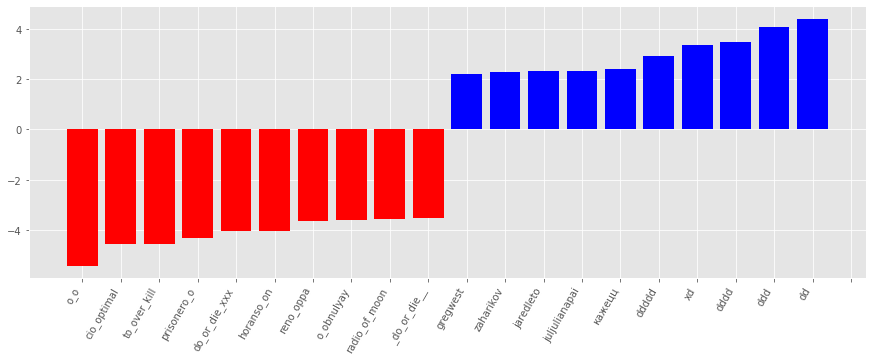

In [17]:
my_vis.visualize_coefficients(classifier, feature_names)

Порог: 0.3861986730297972
Принцип выбора порога: maxf
Процентов теста в бане:  60.48
lift: 1.40 

              precision    recall  f1-score   support

           0       0.80      0.64      0.71     22440
           1       0.71      0.85      0.77     22927

    accuracy                           0.75     45367
   macro avg       0.76      0.74      0.74     45367
weighted avg       0.75      0.75      0.74     45367



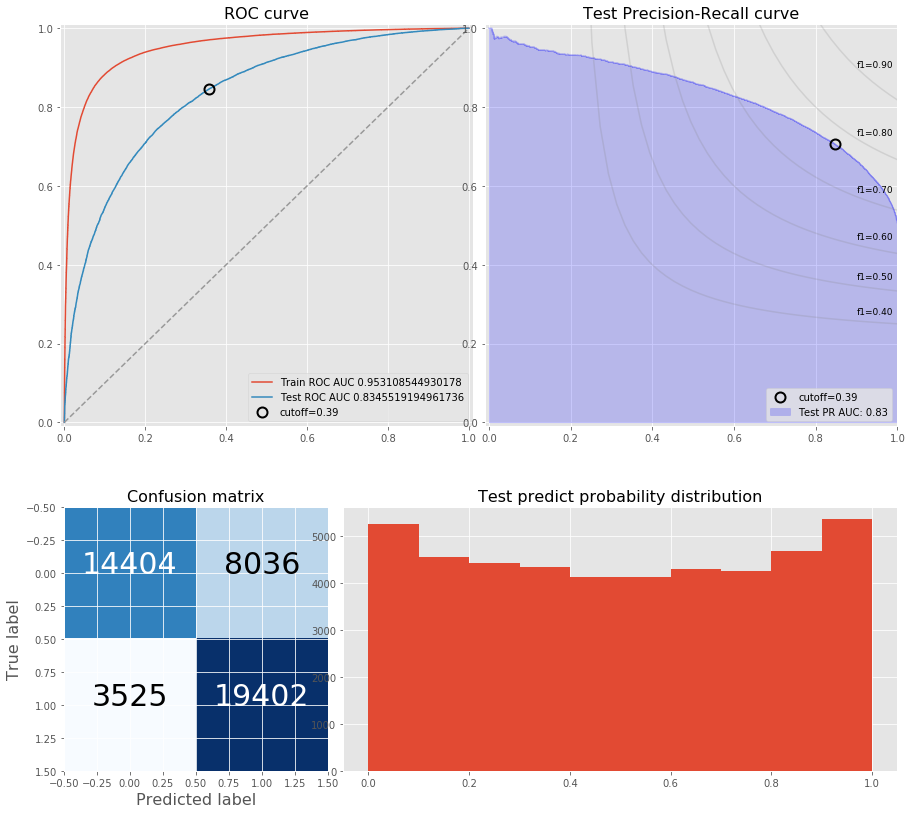

In [18]:
my_vis.classification_quality_report(model_cv, X_train, X_test, y_train, y_test)

Теперь давайте попробуем обучить такую же модель но на текстах без предобработки.

In [19]:
# Собираем модель из двух шагов (cv - count_vectorizer)
model_noprepare = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', LogisticRegression(C=1))
            ])

model_noprepare.fit(texts_train, y_train)

C:\Users\roma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
               

Порог: 0.3817387732844596
Принцип выбора порога: maxf
Процентов теста в бане:  59.96
lift: 1.42 

              precision    recall  f1-score   support

           0       0.81      0.66      0.73     22440
           1       0.72      0.85      0.78     22927

    accuracy                           0.76     45367
   macro avg       0.77      0.76      0.75     45367
weighted avg       0.77      0.76      0.75     45367



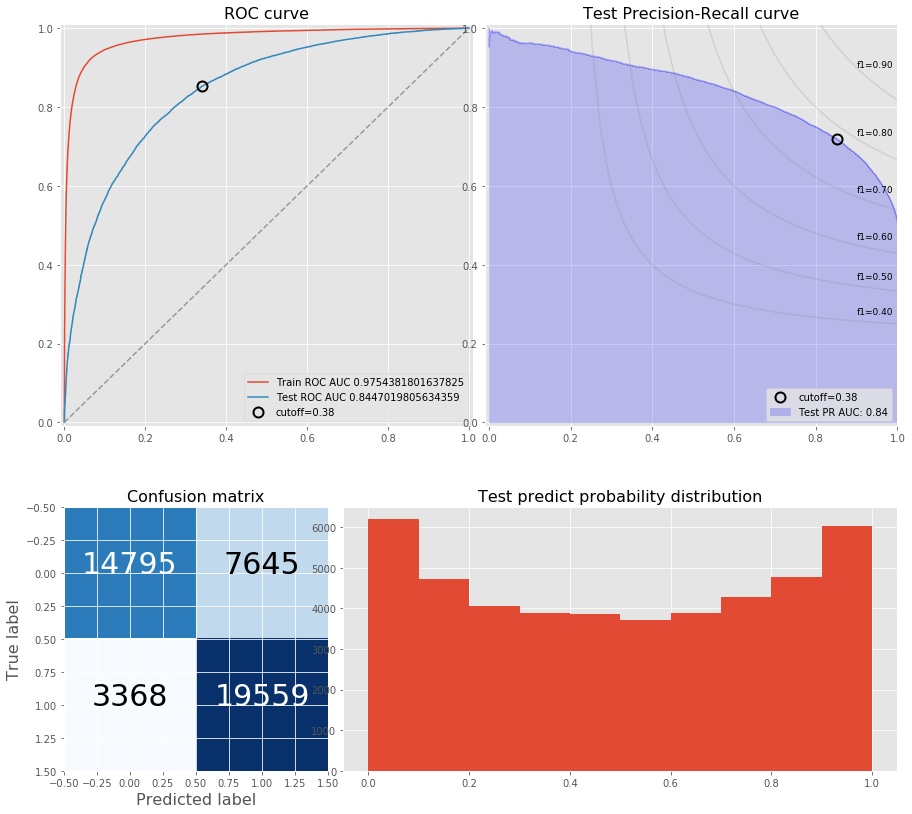

In [20]:
my_vis.classification_quality_report(model_noprepare, texts_train, texts_test, y_train, y_test)

## 4. Пытаемся улучшить модель

**Задание 1:** Модель вышла не самой удачной. Давайте попробуем обучить точно такую же модель, но с tf-idf векторизацией. Отфильтруем из векторайзера все очень частые и редкие слова так, чтобы фичей осталось не очень много. На самом деле параметры для фильтрации это гипер-параметры и их тоже можно подбирать в ходе поиска по решётке. Также как и силу регуляризации. 

In [21]:
# Ваша tf-idf модель, которая побила предыдущую модель

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

model_tfidf = Pipeline([
            ('vectorizer', TfidfVectorizer(min_df=5, max_df=0.5)),
            ('classifier', LogisticRegression(C=1))
            ])

model_tfidf.fit(X_train, y_train)

C:\Users\roma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, interce

Порог: 0.43027172372225614
Принцип выбора порога: maxf
Процентов теста в бане:  60.43
lift: 1.39 

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     22440
           1       0.70      0.84      0.76     22927

    accuracy                           0.74     45367
   macro avg       0.75      0.74      0.73     45367
weighted avg       0.75      0.74      0.74     45367



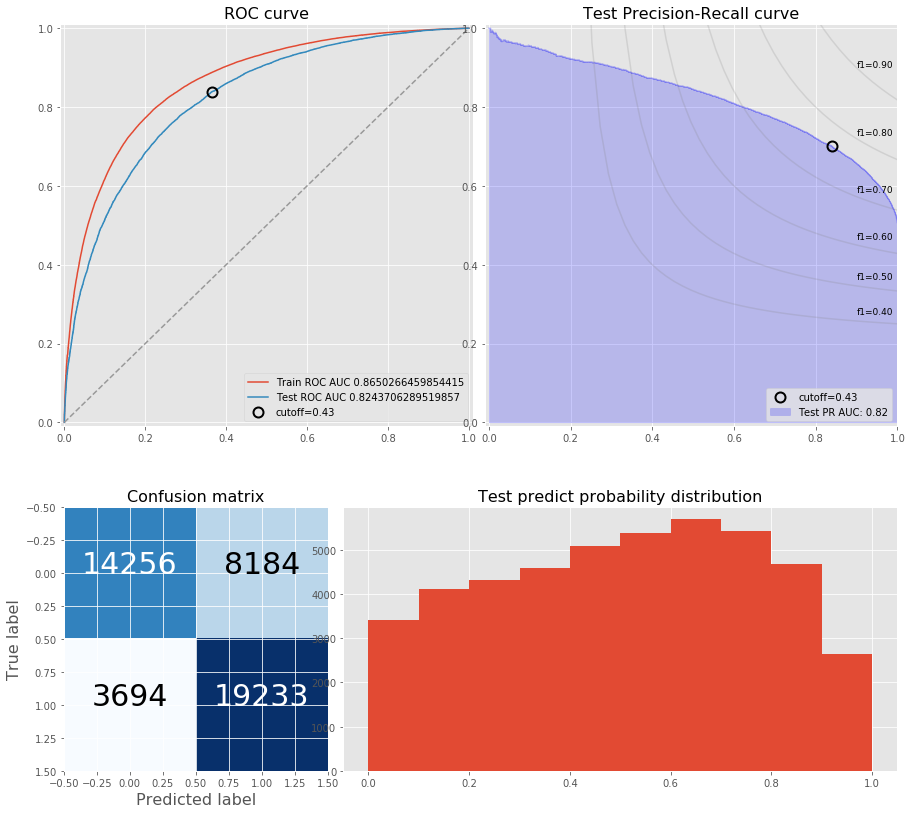

In [23]:
my_vis.classification_quality_report(model_tfidf, X_train, X_test, y_train, y_test)

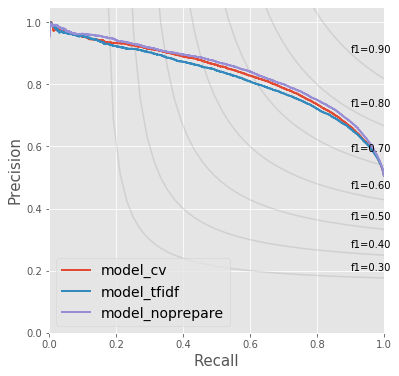

In [24]:
my_vis.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_cv.predict_proba(X_test)[:,-1],
                   model_tfidf.predict_proba(X_test)[:,-1],
                   model_noprepare.predict_proba(texts_test)[:,-1]],
    labels=['model_cv', 'model_tfidf', 'model_noprepare'])

Теперь попробуйте добавить в модель в рамках tf-idf биграммы. Приводит ли это к улучшению модели? 

In [25]:
# Ваша tf-idf модель c биграммами

Визуализируйте топ-10 положительных коэффициентов и топ-10 отрицательных. Логичные ли получились коэффициенты? 

In [26]:
# ваш код

## 5. Новый пайплайн

На лекции мы с вами выяснили, что главная беда анализа текстов - высокая размерность матрицы термы-на-документы. Давайте попробуем эту беду побороть. Для этого вспомним метод главных компонент, который позволяет сжать пространство высокой размерность во что-то более маленькое и приятное. Используйте для сжатия `TruncatedSVD`. Это реализация PCA, которая работает для разряженных матриц. Нужно добавить SVD в наш вычислительный пайплайн в качестве отдельного шага. 

In [ ]:
# Ваш код 

from sklearn.decomposition import TruncatedSVD

model_svd = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('svd', TruncatedSVD(1000)),
            ('classifier', LogisticRegression(C=1))
        ])

model_svd.fit(X_train, y_train)

In [ ]:
my_vis.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_cv.predict_proba(X_test)[:,-1],
                   model_tfidf.predict_proba(X_test)[:,-1],
                   model_noprepare.predict_proba(texts_test)[:,-1],
                   model_svd.predict_proba(X_test)[:,-1]],
    labels=['model_cv', 'model_tfidf', 'model_noprepare'])

## 6. Применяем модель.

Выбирете лучшую из своих моделей. Сейчас мы попытаемся применить её на практике. Делай раз. Подбираем порог для позитива и негатива. 

In [28]:
# Ваш код 

Делай два. Подгружаем новую табличку с твиттами и прогоняем по ней нашу модель. 

In [29]:
def table_prepare(path, model=model_cv):

    df = pd.read_csv(path, sep='\t')
    df = df[['Tweets', 'Date']]

    # предобработали дату
    df.Date = df.Date.apply(lambda x: x.split(' ')[2] + ' ' 
                        + x.split(' ')[1] + ' ' + x.split(' ')[-1])

    # по очереди применяем все предобрабатывающие функции
    df['prepareTweets'] = df.Tweets.apply(prepare_text)

    print("Размер таблицы: ", df.shape)
    # финальная предобработка (добавление нулей)
    X = df.prepareTweets.values

    # предсказываем вероятность негатива
    prob = model.predict_proba(X)[:,-1]
    df['prob'] = prob
    return df[['Date', 'Tweets', 'prob']]

Делай три. Рисуем весёлую картинку. 

In [30]:
def negative_plot(df, cutoff_neg=0.65, cutoff_pos=0.45):
    df['Negative'] = df.prob < cutoff_pos
    df['Positive'] = df.prob > cutoff_neg
    df['Neutral'] = (df.prob <= cutoff_neg) | (df.prob >= cutoff_pos)

    df_abs = df[['Date', 'Positive', 'Neutral','Negative']].groupby('Date').sum()
    df_perc = df_abs.divide(df_abs.sum(axis=1), axis=0)
    
    # строим красивую картинку 
    plt.figure(figsize=(14,6))

    # colors: https://www.color-hex.com/color/2ecc71
    pal = ["#e74c3c", "#f1c40f", "#2ecc71"]

    plt.stackplot(df_perc.index, df_perc['Negative'],  df_perc['Neutral'], df_perc['Positive'], 
                        labels=['Negative','Neutral','Positive'],  colors=pal)

    plt.legend(loc='lower right')
    plt.margins(0,0)
    plt.title('Доли твитов определённой тональности',size=18)
    plt.show()
    pass 

Поихали. 

### Что люди пишут в твиттере о кино?

In [31]:
df_rapsodia = table_prepare('twitter_datasets/df_film_rapsodia.csv')
df_rapsodia.head()

Размер таблицы:  (4412, 3)


,Date,Tweets,prob
0,23 Nov 2018,#ВечернийУргант. Богемская рапсодия 🔥 https://...,0.82
1,27 Nov 2018,@thnksmom_ Богемская рапсодия,0.39
2,27 Nov 2018,"окей, богемская рапсодия выдавила из меня слезу.",0.39
3,27 Nov 2018,"""Богемская рапсодия""-прекрасный подбор актеров...",0.99
4,27 Nov 2018,RT @assambleya: богемская рапсодия би лайк htt...,0.61


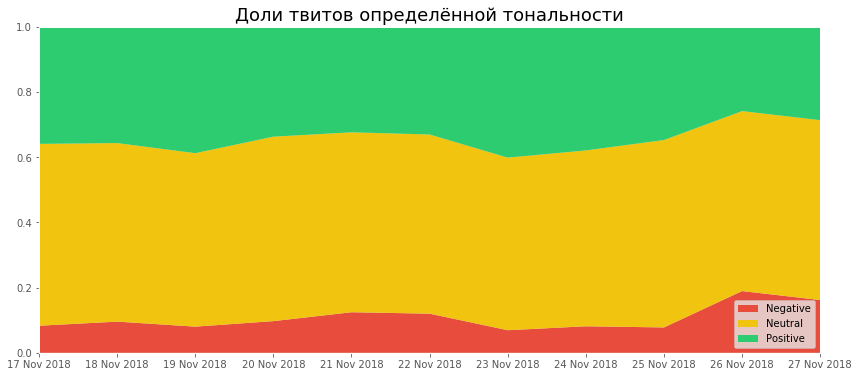

In [32]:
negative_plot(df_rapsodia)

In [33]:
df_fantastic = table_prepare('twitter_datasets/df_film_fantastic.csv')
df_fantastic.head()

Размер таблицы:  (11886, 3)


,Date,Tweets,prob
0,18 Nov 2018,"Интересно, включены ли в тест фантастические т...",0.61
1,22 Nov 2018,Фантастические твари и сколько ещё они будут т...,0.22
2,27 Nov 2018,RT @Chehovskyi: Фантастические твари и как они...,0.28
3,27 Nov 2018,15 ноября при поддержке Европы Плюс в прокат в...,0.67
4,27 Nov 2018,RT @metashot: 1918 год - издательство заказыва...,0.45


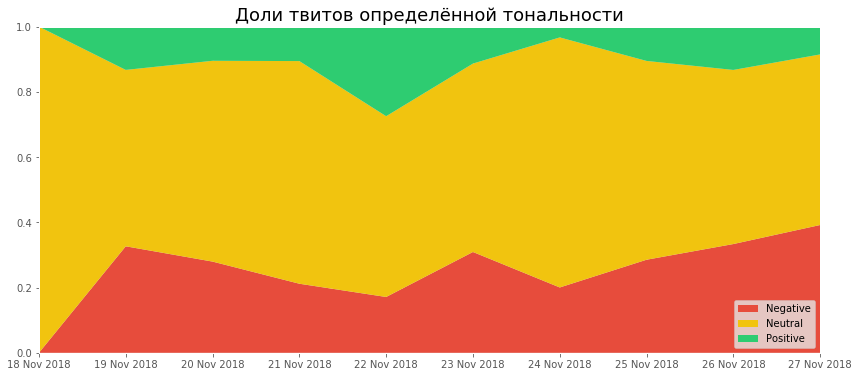

In [34]:
negative_plot(df_fantastic)

In [35]:
# пример позитива
df_fantastic[df_fantastic.prob > 0.9].Tweets.iloc[0]

'@Stony_fan Пойду фантастические твари смотреть.  Обожаю первую часть.\nКстати сегодня приснился Грейвз.  Он был наши… https://t.co/Fo3L4YqrXD'

In [36]:
# пример негатива
df_fantastic[df_fantastic.prob < 0.1].Tweets.iloc[0]

'RT @missis_Di: Фантастические твари, и почему они стоят передо мной в очереди в банкомат?!?!'

### Что люди пишут в твиттере о банках?

In [37]:
df_sber = table_prepare('twitter_datasets/df_sber.csv')
df_sber.head()

Размер таблицы:  (7076, 3)


,Date,Tweets,prob
0,27 Nov 2018,Сбербанк прокомментировал сообщения о блокиров...,0.68
1,27 Nov 2018,Сбербанк уведомил Еврокомиссию об утечке персо...,0.70
2,27 Nov 2018,RT @bloginmydreams: Сбербанк - рабовладелец му...,0.97
3,27 Nov 2018,RT @bloginmydreams: Сбербанк - рабовладелец му...,0.97
4,27 Nov 2018,"бля читал ""север против юга(Жюль Верн)"",про гр...",0.71


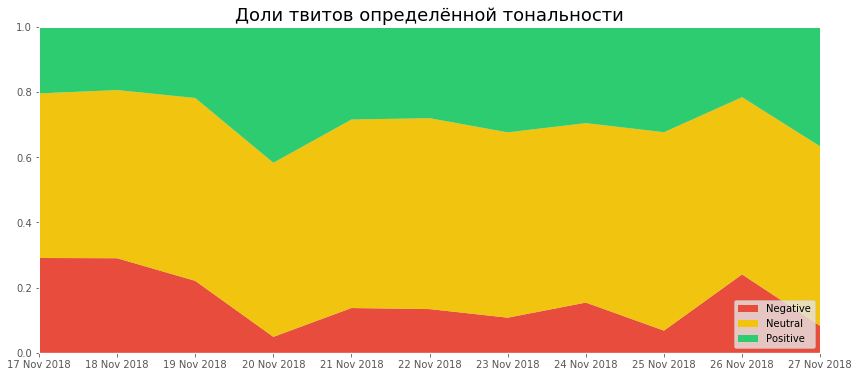

In [38]:
negative_plot(df_sber)

In [39]:
df_tinkoff = table_prepare('twitter_datasets/df_tinkoff.csv')
df_tinkoff.head()

Размер таблицы:  (2882, 3)


,Date,Tweets,prob
0,27 Nov 2018,RT @ru_thebell: Лучшими мобильными приложениям...,0.93
1,27 Nov 2018,хочу помочь финансово хоть как-то но тинькофф ...,0.22
2,27 Nov 2018,"RT @_U_R_I_c: Догадайтесь, у кого все хорошо?\...",0.97
3,27 Nov 2018,Подравнять шмоньку в Бест Клиник можно было за...,0.96
4,27 Nov 2018,@n_fonok @yoshkinkrot Враньё. Тинькофф и Сбер ...,0.71


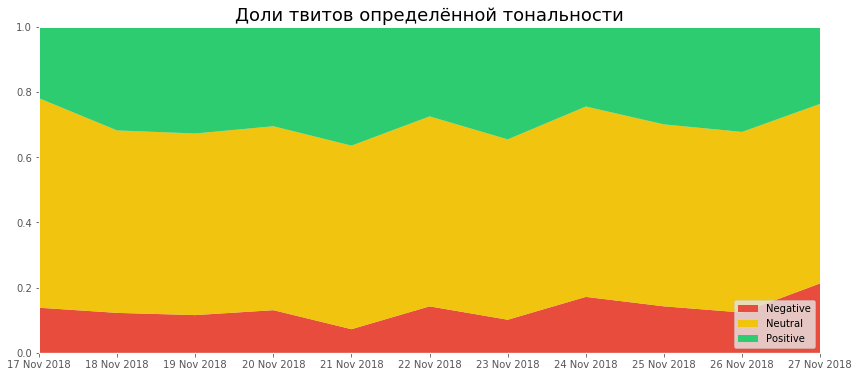

In [40]:
negative_plot(df_tinkoff)

### Что люди пишут в твиттере о рэпе?

In [41]:
df_basta = table_prepare('twitter_datasets/df_basta.csv')
df_basta.head()

Размер таблицы:  (8187, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.89
1,26 Nov 2018,"#ябудупетьсвоюмузыку\nААААА Баста, Нойз и Окси...",0.84
2,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.79
3,27 Nov 2018,"Мне понравилось видео ""Баста feat. Noize MC и ...",0.63
4,27 Nov 2018,RT @norimyxxxo: Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБас...,0.57


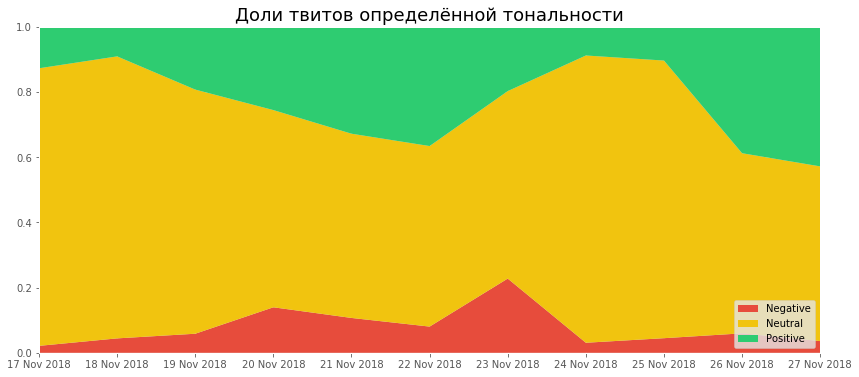

In [42]:
negative_plot(df_basta)

In [43]:
df_noize = table_prepare('twitter_datasets/df_noize.csv')
df_noize.head()

Размер таблицы:  (6869, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.89
1,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.79
2,24 Nov 2018,"Оксимирон, Баста и Noize MC проведут концерт в...",0.36
3,27 Nov 2018,RT @KoleNikita: Чтобы вы понимали!\n\nНа одной...,0.67
4,27 Nov 2018,"Музыка WG Fest 2018: Sabaton, «Звери» и Noize ...",0.78


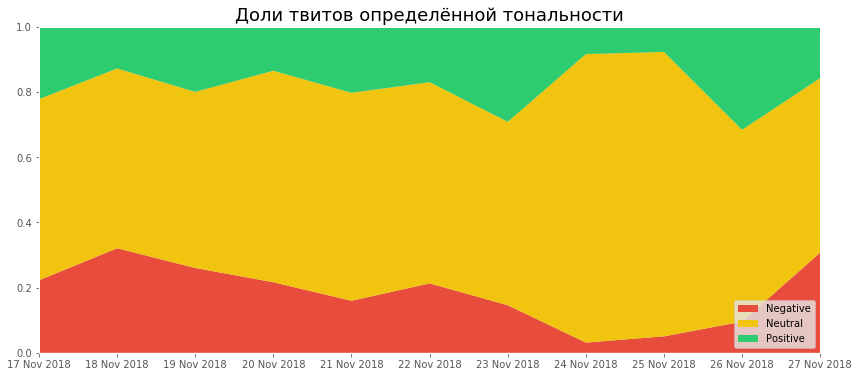

In [44]:
negative_plot(df_noize)

In [45]:
df_oxxy = table_prepare('twitter_datasets/df_oxxy.csv')
df_oxxy.head()

Размер таблицы:  (5384, 3)


,Date,Tweets,prob
0,26 Nov 2018,Oxxxymiron / Баста / Noize MC. Мы будем целико...,0.89
1,24 Nov 2018,"Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБаста, Oxxxymiron, ...",0.79
2,24 Nov 2018,#ябудупетьсвоюмузыку\nКупил два билета на конц...,0.78
3,27 Nov 2018,"Мне понравилось видео ""Баста feat. Noize MC и ...",0.63
4,27 Nov 2018,RT @norimyxxxo: Я БУДУ ПЕТЬ СВОЮ МУЗЫКУ: \nБас...,0.57


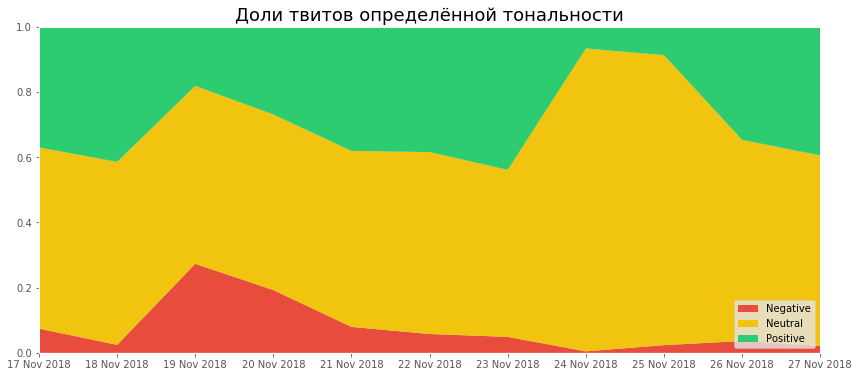

In [46]:
negative_plot(df_oxxy)

### Ваши идеи

In [47]:
# ?????

## 7. Эксперименты с деревьями 

На лекции мы обсудили, что деревья, будстинг и тп не очень заходят для решения задач, связаннх с текстами. Давайте убедимся, что они и правда работают хуже. Для экспериментов возьмём небольшой кусочек от базовой выборки. 

Пришло време деревьев. Подгружаем классифайер для случайного леса и бустинг. 

In [48]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Соберите два пайплайна: `CountVectorizer() -> TruncatedSVD(100) -> Randomforest(100)` и такой же с бустингом. Насколько высоким оказывается качество? 

In [49]:
# Ваш код

Увеличьте количество компонент и деревьев до $1000$. Стало ли лучше? 

In [50]:
# Ваш код

Попробуйте взять в качестве векторайзера tf-idf. Удалось ли улучшить результат? 

In [51]:
# Ваш код

Выберите лучшую модель с деревьями. Бьёт ли она результаты вашей лучшей регрессии? Почему при сопостовимом качестве моделей имеет смысл остановиться на регрессии и не трогать деревья? 

In [52]:
# Ваш код

## 8.  Наивный байес 

Иногда одним из самых первых алгоритмов, среди натравливаемых на тексты на равне с логистической регрессией, оказывается наивный байесовский классификатор. 

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Каждый документ –  мешок слов, всего слов $|V|$.
	
* $p(c)$ – априорная вероятность класса $c$
* $p(c|d)$ – апостериорная вероятность класса $c$
* $ p(c|d) = \frac{p(d|c)p(c)}{p(d)} $


В мультиномиальной байесовской модели документ – это последовательность событий. Каждое событие – этослучайный выбор одного слова из мешка слов. Когда мы подсчитываем правдоподобие документа, мы перемножаем вероятности того, что мы достали из мешка те самые слова, которые встретились в документе. 

Наивное предположение в том, что мы достаём из мешка разные слова независимо друг от друга, т.е. вероятности признаков внутри класса независимы.

Получается мультиномиальная генеративная модель, которая учитывает количество повторений каждого слова, но не учитывает порядок этих слов, а также каких слов нет в документе.

* [Подробнее о различных видах байесовских классификаторов](https://logic.pdmi.ras.ru/~sergey/teaching/mlaptu11/03-classifiers.pdf).
* [Слайды Дмитрия Игнатова про классификацию](https://cs.hse.ru/data/2016/04/13/1129765566/Classification.pdf)

-------------------------

Давайте попробуем обучить наивную Байесовскую модель. Сделаем это точно также, как и с предыдущими моделями, в виде пайплайна. В качестве первого шага пайплайна попробуйте оба векторайзера по очереди. 

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
# Ваш код

model_nb = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', MultinomialNB())
        ])

model_nb.fit(X_train, y_train);

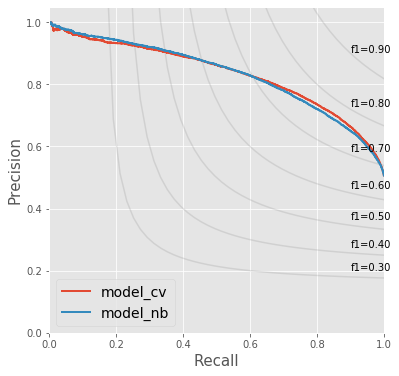

In [55]:
my_vis.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_cv.predict_proba(X_test)[:,-1],
                   model_nb.predict_proba(X_test)[:,-1]],
    labels=['model_cv', 'model_nb'])

## 9. Сравниваем всё, что намоделировали!

Постройте все получившиеся precision-recall кривые на одной картинке. Какая самая классная f-мера получилась? Имейте в виду, что разметка твиттера, которой мы пользуемся, была сделана в полуавтоматическом режиме. Сама автор разметки оценивает её качество на уровне 80%. Выборка сбалансированная. Обычно получается, что accuracy на ней в районе $0.75$. Если вы добрались до такой отметины, ваша модель хороша. Если вы пробили 0.8, то вы умудрились оверфитнутся. Поздравляю. 

In [56]:
# Ваш код

Осталось время? (маловероятно). Тогда попробуем трюк с хэшированием м обсудим, почему, на мой взгляд, его никогда не надо пробовать.

![](https://hsto.org/webt/gw/-l/bs/gw-lbsso67kzbcmb8oibvw-pn1u.png)